In [20]:
import os
from typing import TypedDict, List, Dict, Any
from dotenv import load_dotenv
from langchain.messages import HumanMessage, AIMessage
from langchain_core.messages.base import BaseMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END ,START
import json



In [5]:
load_dotenv()
llm_key = os.getenv('llm_key')

In [7]:
model=ChatOpenAI(model="openai/gpt-oss-20b:free",
                        api_key=llm_key,
                        base_url="https://openrouter.ai/api/v1")
response = model.invoke("What is the capital of France?")
print(response)

content='The capital of France is **Paris**.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 74, 'total_tokens': 116, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 64}, 'reasoning_tokens': 0}, 'model_provider': 'openai', 'model_name': 'openai/gpt-oss-20b:free', 'system_fingerprint': None, 'id': 'gen-1764595922-asN0S07gla7NRMKw9eJP', 'finish_reason': 'stop', 'logprobs': None} id='lc_run--beabe1f8-1085-42f7-aad6-9e1a918bad22-0' usage_metadata={'input_tokens': 74, 'output_tokens': 42, 'total_tokens': 116, 'input_token_details': {'cache_read': 64}, 'output_token_details': {}}


In [10]:
class GraphState(TypedDict):
    user_request: str
    questions: Dict[str, Any]
    answers: Dict[str, Any]
    validation: Dict[str, Any]
    workflow: Dict[str, Any]

In [36]:
def generate_questions(state: GraphState):

    prompt = f"""
You are a workflow architect building workflows for a university.

User wants: {state['user_request']}

Generate REQUIRED questions in EXACT JSON format:

{{
  "workflow_type": "letter_of_recommendation",
  "required_fields": [
    {{
      "id": "student_name",
      "question": "...",
      "type": "string",
      "required": true
    }}
  ],
  "optional_fields": []
}}

Only output JSON.
"""

    response = model.invoke([HumanMessage(content=prompt)])

    try:
        questions = json.loads(response.content)
    except:
        raise Exception("Invalid JSON returned by model")

    return {"questions": questions}

def validate_answers(state: GraphState):

    questions = state["questions"]
    answers = state["answers"]

    missing = []

    for field in questions["required_fields"]:
        if field["id"] not in answers or answers[field["id"]] in [None, "", []]:
            missing.append(field["question"])

    if missing:
        return {
            "validation": {
                "valid": False,
                "missing": missing
            }
        }

    return {
        "validation": {
            "valid": True
        }
    }


def generate_power_automate_workflow(state: GraphState):

    answers = state["answers"]

    prompt = f"""
You are a Microsoft Power Automate expert.

Based on the following information, generate a Power Automate workflow in JSON:

{json.dumps(answers, indent=2)}

Return in this format:

{{
  "workflow_name": "...",
  "trigger": {{ }},
  "steps": [ ]
}}

Return ONLY JSON.
"""

    response = model.invoke([HumanMessage(content=prompt)])

    try:
        workflow = json.loads(response.content)
    except:
        raise Exception("Workflow generation failed")

    return {"workflow": workflow}

def ask_questions_node(state: GraphState):

    questions = state.get("questions")

    if not questions or "required_fields" not in questions:
        print("\n❌ No questions found in state.")
        return state

    answers = {}

    print("\nAnswer the following:\n")

    for field in questions["required_fields"]:
        val = input(f"{field['question']}: ")
        answers[field["id"]] = val

    return {
        "answers": answers
    }


def decider(state: GraphState):
    """
    If validation fails → generate new/refined questions
    If validation passes → generate workflow
    """

    if state["validation"]["valid"] is True:
        return "workflow_generator"
    else:
        return "question_generator"

In [ ]:
graph = StateGraph(GraphState)
graph.add_node("question_generator", generate_questions)
graph.add_node("human_answer_collector", ask_questions_node)
graph.add_node("validator", validate_answers)
graph.add_node("workflow_generator", generate_power_automate_workflow)
graph.add_node("dec",lambda state:state)
graph.add_conditional_edges(
    "dec",
    decider, 
    {
        "question_generator": "question_generator",
        "workflow_generator": "workflow_generator"
    }
)

# graph.set_entry_point("question_generator")

# # Conditional flow
# def route_validation(state: GraphState):
#     if state["validation"]["valid"] == True:
#         return "workflow_generator"
#     else:
#         return END

# graph.add_edge("question_generator", "validator")
# graph.add_conditional_edges("validator", route_validation)
# graph.add_edge("workflow_generator", END)

graph.set_entry_point("question_generator")
graph.add_edge('question_generator',"human_answer_collector")
graph.add_edge("human_answer_collector",'validator')
graph.add_edge('validator','dec')
graph.add_edge('workflow_generator',END)
app = graph.compile()

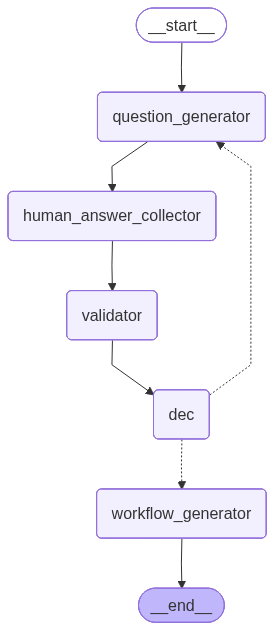

In [38]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [39]:
user_input = 'build me a leave letter workflow'
state = {
        "user_request": user_input,
        "questions": {},
        "answers": {},
        "validation": {},
        "workflow": {}
    }

final_state = app.invoke(state)

print("\n✅ Power Automate Workflow Generated:\n")
print(json.dumps(final_state["workflow"], indent=2))


Answer the following:


✅ Power Automate Workflow Generated:

{
  "workflow_name": "Student Leave Application",
  "trigger": {
    "type": "MicrosoftForms",
    "trigger_id": "When_a_new_response_is_submitted",
    "form_id": "LeaveApplicationForm",
    "details": {
      "form_name": "Student Leave Request",
      "fields": [
        {
          "name": "student_name",
          "type": "Text"
        },
        {
          "name": "student_id",
          "type": "Text"
        },
        {
          "name": "department",
          "type": "Text"
        },
        {
          "name": "leave_type",
          "type": "Choice"
        },
        {
          "name": "leave_start_date",
          "type": "Date"
        },
        {
          "name": "leave_end_date",
          "type": "Date"
        },
        {
          "name": "leave_reason",
          "type": "Text"
        },
        {
          "name": "application_date",
          "type": "Date"
        }
      ]
    }
  },
  "ste